![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [318]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Import any additional modules and start coding below

In [319]:
rental_info = pd.read_csv("rental_info.csv", parse_dates = ["return_date", "rental_date"])
print(rental_info.info())
rental_info.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   rental_date       15861 non-null  datetime64[ns, UTC]
 1   return_date       15861 non-null  datetime64[ns, UTC]
 2   amount            15861 non-null  float64            
 3   release_year      15861 non-null  float64            
 4   rental_rate       15861 non-null  float64            
 5   length            15861 non-null  float64            
 6   replacement_cost  15861 non-null  float64            
 7   special_features  15861 non-null  object             
 8   NC-17             15861 non-null  int64              
 9   PG                15861 non-null  int64              
 10  PG-13             15861 non-null  int64              
 11  R                 15861 non-null  int64              
 12  amount_2          15861 non-null  float64            
 13  l

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


**1. Getting the number of rental days.**

In [320]:
rental_info['rental_length_days'] = rental_info['return_date'] - rental_info['rental_date']
rental_info['rental_length_days'] = rental_info['rental_length_days'].dt.days

**2. Adding dummy variables using the special features column.**

In [321]:
has_behind = rental_info['special_features'].str.contains('Behind the Scenes', regex=False)
has_deleted = rental_info['special_features'].str.contains('Deleted Scenes', regex=False)
has_both = has_behind & has_deleted

rental_info['special_features'] = np.select(
    condlist=[has_both, has_behind, has_deleted],
    choicelist=[
        '{"Behind the Scenes","Deleted Scenes"}',  
        '{"Behind the Scenes"}',                   
        '{"Deleted Scenes"}'                       
    ],
    default=rental_info['special_features']        
)
special_features = rental_info['special_features'].unique()
special_features

array(['{"Behind the Scenes"}', '{Trailers}', '{Trailers,Commentaries}',
       '{"Behind the Scenes","Deleted Scenes"}', '{"Deleted Scenes"}',
       '{Commentaries}'], dtype=object)

In [322]:
special_features = rental_info['special_features'].unique()
special_features_to_keep = np.isin(special_features, ['{"Behind the Scenes"}', '{"Deleted Scenes"}', '{"Behind the Scenes","Deleted Scenes"}'])
special_features_to_drop = special_features[~special_features_to_keep]
special_features_to_drop

array(['{Trailers}', '{Trailers,Commentaries}', '{Commentaries}'],
      dtype=object)

In [323]:
rental_info_dummies = pd.get_dummies(rental_info, columns=["special_features"], prefix="", prefix_sep="")
rental_info_dummies = rental_info_dummies.drop(special_features_to_drop, axis=1)
rental_info_dummies.rename(columns=lambda x: x.replace('{"Deleted Scenes"}', "deleted_scenes"), inplace=True)
rental_info_dummies.rename(columns=lambda x: x.replace('{"Behind the Scenes"}', "behind_the_scenes"), inplace=True)
rental_info_dummies.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,"{""Behind the Scenes"",""Deleted Scenes""}",behind_the_scenes,deleted_scenes
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,3,0,1,0
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,2,0,1,0
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,7,0,1,0
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,2,0,1,0
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,4,0,1,0


In [324]:
rental_info_dummies['behind_the_scenes'] = (
    (rental_info_dummies['behind_the_scenes'] == 1) | 
    (rental_info_dummies['{"Behind the Scenes","Deleted Scenes"}'] == 1)
).astype(int)
rental_info_dummies['deleted_scenes'] = (
    (rental_info_dummies['deleted_scenes'] == 1) | 
    (rental_info_dummies['{"Behind the Scenes","Deleted Scenes"}'] == 1)
).astype(int)
rental_info_dummies = rental_info_dummies.drop(['{"Behind the Scenes","Deleted Scenes"}'], axis=1)
rental_info_dummies.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,behind_the_scenes,deleted_scenes
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,3,1,0
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,2,1,0
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,7,1,0
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,2,1,0
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,4,1,0


**3. Executing a train-test split**\
Make a pandas DataFrame called X containing all the appropriate features you can use to run the regression models, avoiding columns that leak data about the target.

In [325]:
safe_columns = [col for col in rental_info_dummies.columns if col not in ["rental_length_days", "rental_date", "return_date"]]
print(len(safe_columns))

X = rental_info_dummies[safe_columns].copy()
y = rental_info_dummies['rental_length_days']

14


In [326]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 9)

**4. Performing feature selection**

[ 5.87567707e-01  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  4.32652862e-02  2.55377037e-06 -1.52154989e-01
  0.00000000e+00 -0.00000000e+00]


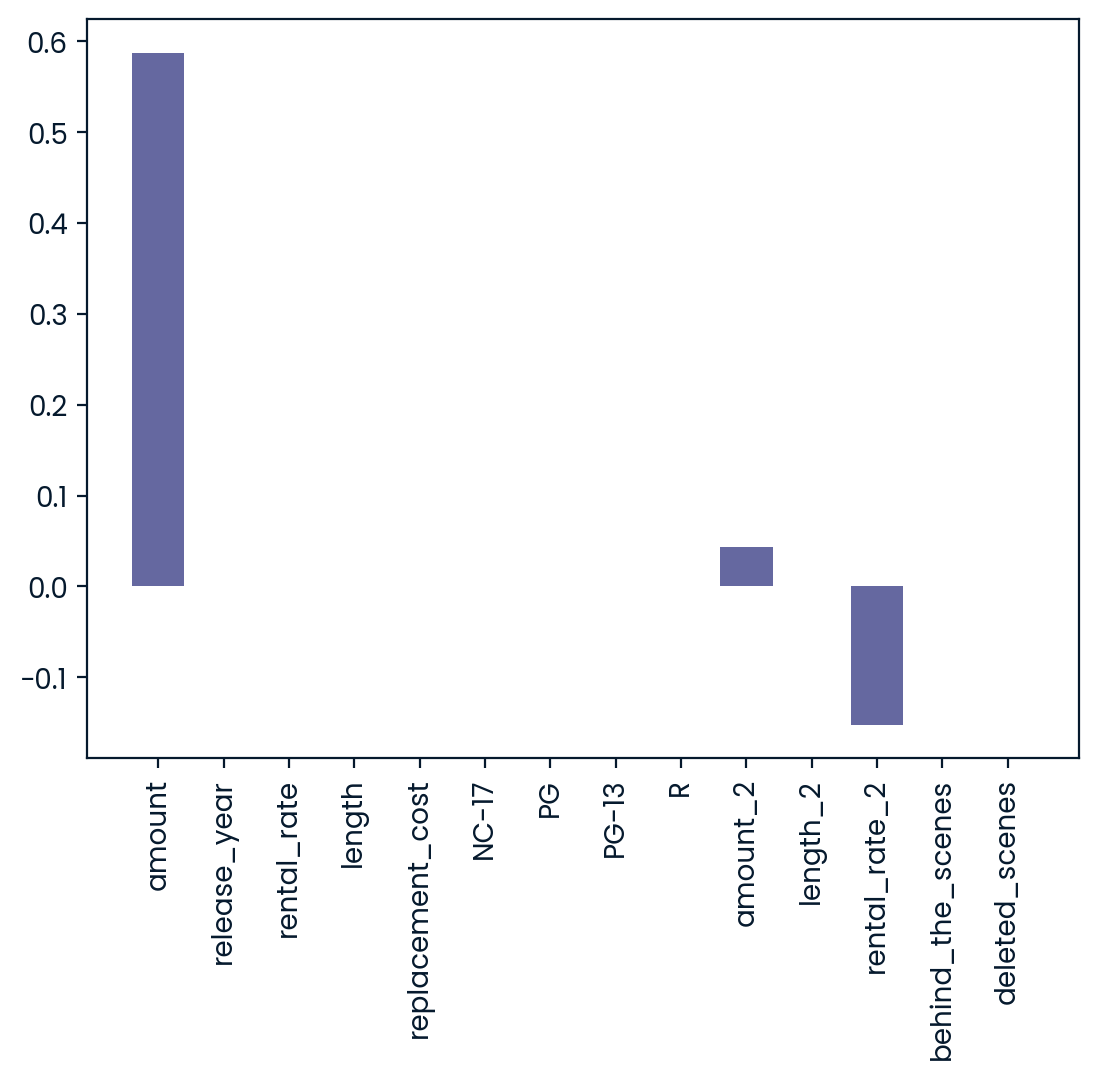

In [327]:
from sklearn.linear_model import Lasso, LinearRegression, Ridge
import matplotlib.pyplot as plt

lasso = Lasso(alpha = 0.3)
lasso.fit(X, y)
lasso_coef = lasso.coef_
print(lasso_coef)
plt.bar(safe_columns, lasso_coef)
plt.xticks(rotation=90)
plt.show()

In [328]:
X_train = X_train[["amount", "rental_rate_2", "amount_2"]] 
X_test = X_test[["amount", "rental_rate_2", "amount_2"]] 

**5. Choosing models and performing hyperparameter tuning**

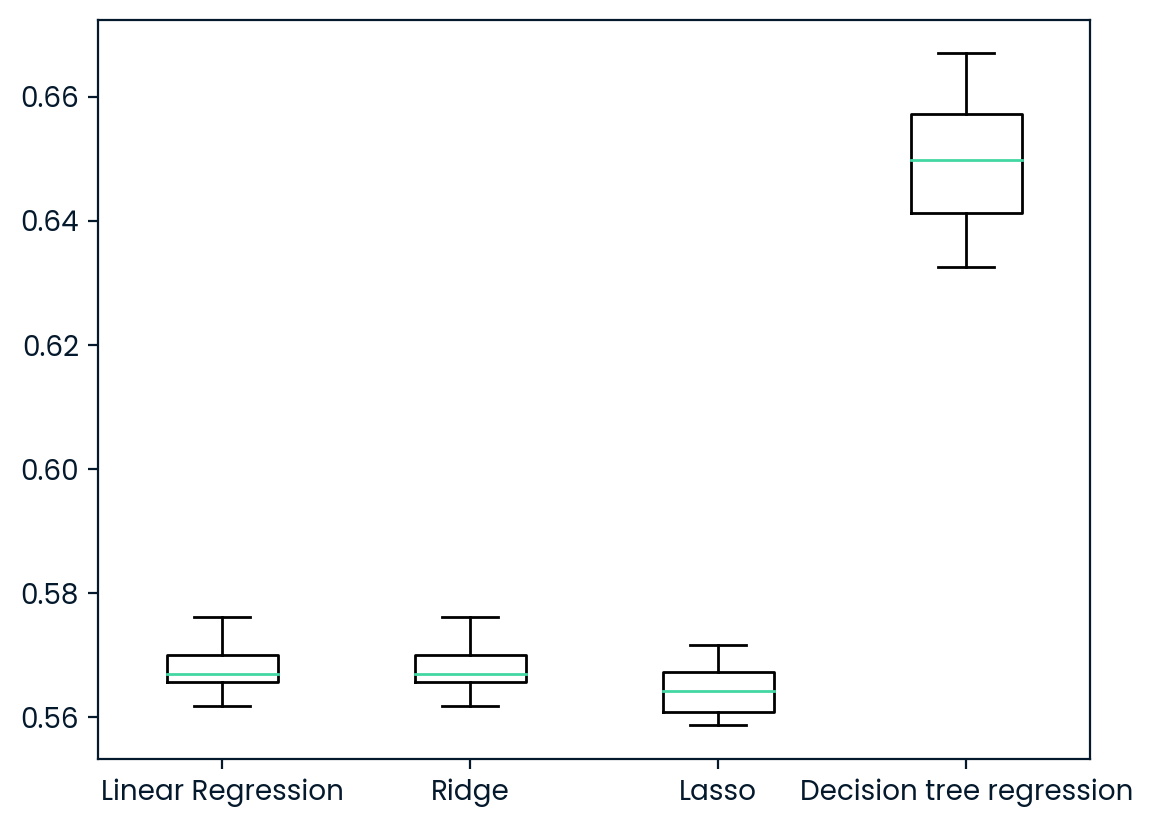

In [329]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

models = {"Linear Regression": LinearRegression(), "Ridge": Ridge(alpha=0.1), "Lasso": Lasso(alpha=0.1), "Decision tree regression": DecisionTreeRegressor()}
results = []

# Loop through the models' values
for model in models.values():
  kf = KFold(n_splits=6, random_state=9, shuffle=True)
  
  # Perform cross-validation
  cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
  
  # Append the results
  results.append(cv_scores)

# Create a box plot of the results
plt.boxplot(results, labels=models.keys())
plt.show()

In [330]:
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

test_rmses = {}

for name, model in models.items():
  steps = [("scaler", StandardScaler()), ("model", model)]

  # Set up pipeline
  pipeline = Pipeline(steps)
  
  # Fit the model to the training data
  pipeline.fit(X_train, y_train)
  
  # Make predictions on the test set
  y_pred = pipeline.predict(X_test)
  
  # Calculate the test_rmse
  test_rmse = mean_squared_error(y_test, y_pred, squared=False)
  test_rmses[name] = test_rmse
  print("{} Test Set RMSE: {}".format(name, test_rmse))

best_model_name = min(test_rmses.items(), key=lambda x: x[1])[0]
best_model = models[best_model_name]
best_rmse = test_rmses[best_model_name]
print(f"Best model: {best_model_name} (RMSE: {best_rmse})")

Linear Regression Test Set RMSE: 1.733460648795037
Ridge Test Set RMSE: 1.733460452845172
Lasso Test Set RMSE: 1.758479328422296
Decision tree regression Test Set RMSE: 1.5531525162641335
Best model: Decision tree regression (RMSE: 1.5531525162641335)


In [331]:
from sklearn.model_selection import GridSearchCV

# Set up the parameter grid for Linear Regression

param_grid = {
    "max_depth": [None, 3, 5, 7, 10],
    "min_samples_leaf": [1, 2, 4]
}

kf = KFold(n_splits=6, random_state=9, shuffle=True)
model_cv = GridSearchCV(best_model, param_grid, cv=kf)

# Fit to the training data
model_cv.fit(X_train, y_train)

# Update best_model with the best estimator found by GridSearchCV
best_model = model_cv.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the test_rmse
best_mse = mean_squared_error(y_test, y_pred, squared=True)

# Output the best parameters and the best score
model_cv.best_params_, model_cv.best_score_, best_mse

({'max_depth': None, 'min_samples_leaf': 1},
 0.6495524196236998,
 2.4122827387776096)